In [1]:
import datetime
import glob

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

import conv_mod

In [2]:
im_size = 128
latent_size = 512
batch_size = 16
cha = 32 #Should be 32
n_layers = int(np.log2(im_size) - 1) -1# 6 for 128 
mixed_prob = 0.9
channels_mult_list = [1,2,4,6,8,16,32,32,64,64]

In [3]:
def latent_z(n):
    # Z 
    return np.random.normal(size=[n, latent_size]).astype('float32')

def noise_image(batch_size):
    return np.random.uniform(size = [batch_size, im_size, im_size, 1]).astype('float32')

#Loss functions
def gradient_penalty(samples, output, weight):
    gradients = K.gradients(output, samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * weight

def crop_to_fit(x):
    height = x[1].shape[1]
    width = x[1].shape[2]
    return x[0][:, :height, :width, :]

def upsample_to_size(x):
    y = im_size // x.shape[2]
    x = K.resize_images(x, y, y, "channels_last",interpolation='bilinear')
    return x

In [4]:
def g_block(x, input_style, input_noise, nb_filters, upsampling = True):
    input_filters = x.shape[-1]
    if upsampling:
        x = keras.layers.UpSampling2D(interpolation='bilinear')(x)
    
    rgb_style = keras.layers.Dense(nb_filters, kernel_initializer = keras.initializers.VarianceScaling(200/x.shape[2]))(input_style)
    style = keras.layers.Dense(input_filters, kernel_initializer = 'he_uniform')(input_style)
    
    noise_cropped = keras.layers.Lambda(crop_to_fit)([input_noise, x]) ########
    d = keras.layers.Dense(nb_filters, kernel_initializer='zeros')(noise_cropped)

    x = conv_mod.Conv2DMod(filters=nb_filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')([x, style])
    x = keras.layers.add([x, d])
    x = keras.layers.LeakyReLU(0.2)(x)

    style = keras.layers.Dense(nb_filters, kernel_initializer = 'he_uniform')(input_style)
    d = keras.layers.Dense(nb_filters, kernel_initializer = 'zeros')(noise_cropped)

    x = conv_mod.Conv2DMod(filters = nb_filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')([x, style])
    x = keras.layers.add([x, d])
    x = keras.layers.LeakyReLU(0.2)(x)

    return x, to_rgb(x, rgb_style)

def d_block(inp, fil, p = True):
    res = keras.layers.Conv2D(fil, 1, kernel_initializer = 'he_uniform')(inp)

    out = keras.layers.Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(inp)
    out = keras.layers.LeakyReLU(0.2)(out)
    out = keras.layers.Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(out)
    out = keras.layers.LeakyReLU(0.2)(out)

    out = keras.layers.add([res, out])

    if p:
        out = keras.layers.AveragePooling2D()(out)

    return out

def to_rgb(inp, style):
    size = inp.shape[2]
    x = conv_mod.Conv2DMod(3, 1, kernel_initializer = keras.initializers.VarianceScaling(200/size), 
                              demod = False)([inp, style])
    return keras.layers.Lambda(upsample_to_size, output_shape=[None, im_size, im_size, None])(x)

In [5]:
class StyleGan(keras.Model):
    def __init__(self, steps = 0, lr = 0.0001, log_steps=None):
        super(StyleGan, self).__init__()
        
        #Models
        self.D = self.make_discriminator()
        self.S = self.make_style_map()
        self.G = self.make_generator()
        
        #Config
        self.LR = lr
        self.steps = steps
        self.beta = 0.999

        self.G_opt = keras.optimizers.Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)
        self.D_opt = keras.optimizers.Adam(lr = self.LR, beta_1 = 0, beta_2 = 0.999)
        
        self.pl_mean = tf.Variable(0, dtype=tf.float32)
        
        logdir = "logs/train_data/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_steps = log_steps
        if log_steps is not None:
            self.file_writer = tf.summary.create_file_writer(logdir)
        
    def make_discriminator(self):
        d_input = keras.layers.Input(shape = [im_size, im_size, 3])
        x = d_input
        
        nb_d_layers = int(np.log2(im_size))
        channels_mult = 1
        nb_D_layer = int(np.log2(im_size)) - 1 
        for channels_mult in channels_mult_list[:nb_D_layer-1]:
            x = d_block(x, channels_mult * cha)
        x = d_block(x, channels_mult_list[nb_D_layer-1] * cha, p = False)
        
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1, kernel_initializer = 'he_uniform')(x)
        return keras.models.Model(inputs = d_input, outputs = x)

    def make_style_map(self):
        S = keras.models.Sequential()
        S.add(keras.layers.Dense(512, input_shape = [latent_size]))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        S.add(keras.layers.Dense(512))
        S.add(keras.layers.LeakyReLU(0.2))
        return S
    
    def make_generator(self):
        inp_style = keras.layers.Input([n_layers, 512])
        inp_noise = keras.layers.Input([im_size, im_size, 1])
    
        #Latent
        x = inp_style[:,0,:1] * 0 + 1

        outs = []

        start_dim = im_size // (2**(n_layers-1))

        x = keras.layers.Dense(start_dim*start_dim*start_dim*cha, activation = 'relu', 
                              kernel_initializer = 'random_normal')(x)
        x = keras.layers.Reshape([start_dim, start_dim, start_dim*cha])(x)

        for i, channels_mult in enumerate(channels_mult_list[:n_layers][::-1]):
            x, r = g_block(x, inp_style[:,i], inp_noise, channels_mult * cha, upsampling = (i!=0))  
            outs.append(r)
        x = keras.layers.add(outs)
        x = keras.layers.Lambda(lambda y: y/2 + 0.5)(x) #Use values centered around 0, but normalize to [0, 1], providing better initialization

        return keras.models.Model(inputs = [inp_style, inp_noise], outputs = x)

    @tf.function
    def tf_train_step(self, images, style1, style2, style2_idx, noise, perform_gp=True, perform_pl=False):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            #Get style information
            w_1 = self.S(style1)
            w_2 = self.S(style2)
            w_space = tf.repeat(tf.stack([w_1,w_2], axis=1),[style2_idx, n_layers-style2_idx],axis=1)
            pl_lengths = self.pl_mean

            #Generate images
            generated_images = self.G([w_space,noise])

            #Discriminate
            real_output = self.D(images, training=True)
            fake_output = self.D(generated_images, training=True)

            #Hinge loss function
            gen_loss = K.mean(fake_output)
            divergence = K.mean(K.relu(1 + real_output) + K.relu(1 - fake_output))
            disc_loss = divergence

            if perform_gp:
                #R1 gradient penalty
                disc_loss += gradient_penalty(images, real_output, 10)

            if perform_pl:
                #Slightly adjust W space
                w_space_2 = []
                for i in range(n_layers):
                    w_slice = w_space[:,i]
                    std = 0.1 / (K.std(w_slice, axis = 0, keepdims = True) + 1e-8)
                    w_space_2.append(w_slice + K.random_normal(tf.shape(w_slice)) / (std + 1e-8))
                w_space_2 = tf.stack(w_space_2, axis=1)
                #Generate from slightly adjusted W space
                pl_images = self.G([w_space_2,noise], training=True)

                #Get distance after adjustment (path length)
                pl_lengths = K.mean(K.square(pl_images - generated_images), axis = [1, 2, 3])
                if self.pl_mean > 0 :
                    gen_loss += K.mean(K.square(pl_lengths - self.pl_mean))

        #Get gradients for respective areas
        gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables + self.S.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)

        #Apply gradients
        self.G_opt.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables + self.S.trainable_variables))
        self.D_opt.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

        return disc_loss, gen_loss, divergence, pl_lengths
    
    def train_step(self, args):
        images, style1, style2, style2_idx, noise = args
        self.steps += 1
        
        apply_gradient_penalty = self.steps % 2 == 0 or self.steps < 10000
        apply_path_penalty = self.steps % 16 == 0
        
        disc_loss, gen_loss, divergence, pl_lengths = self.tf_train_step(images, style1, style2, 
                                                                         style2_idx, noise, 
                                                                         apply_gradient_penalty, 
                                                                         apply_path_penalty)
        
        if self.pl_mean == 0:
            self.pl_mean.assign(tf.reduce_mean(pl_lengths))
        self.pl_mean.assign(0.99*self.pl_mean + 0.01*tf.reduce_mean(pl_lengths))
        
        if self.log_steps and not self.steps % self.log_steps:
            with self.file_writer.as_default():
                noise = noise_image(9)
                l_z = latent_z(9)
                l_w = self.S(l_z)
                style = tf.stack([l_w for i in range(n_layers)],axis=1)
                generated = self.G([style,noise])
                img = tf.concat([tf.concat([generated[3*i+k] for k in range(3)], axis=1) for i in range(3)], axis=0)
                tf.summary.image("Training data", [img], step=self.steps)
        
        return {
            "disc_loss":disc_loss,
            "gen_loss":gen_loss,
            "divergence":divergence,
            "pl_lengths":pl_lengths,
        }
            

In [6]:
def read_image(im_path):
    im_file = tf.io.read_file(im_path)
    im = tf.io.decode_jpeg(im_file, channels=3)
    im = tf.image.resize(im, (im_size,im_size))
    im = tf.image.convert_image_dtype(im, tf.float32)/255
    im = tf.image.random_flip_left_right(im)
    return im

def train_dataset():
    path = "/Data/leo/dogs-face-2015/*.jpg"
    im_dataset = tf.data.Dataset.list_files(path)
    im_dataset = im_dataset.map(read_image)
    im_dataset = im_dataset.repeat()
    im_dataset = im_dataset.batch(batch_size)
    
    nb_train_image = len(glob.glob(path))
    print("Number of train images found:", nb_train_image)
    
    def gen_latent_z():
        while 1:
            yield latent_z(batch_size)
 
    def gen_noise():
        while 1:
            yield noise_image(batch_size)
            
    def gen_mixed_idx():
        while 1:
            if np.random.random() < mixed_prob:
                yield np.random.randint(n_layers)
            else:
                yield n_layers
                       
    latent_z1_dataset = tf.data.Dataset.from_generator(gen_latent_z, tf.float32, output_shapes=(batch_size, latent_size))
    latent_z2_dataset = tf.data.Dataset.from_generator(gen_latent_z, tf.float32, output_shapes=(batch_size, latent_size))
    noise_dataset = tf.data.Dataset.from_generator(gen_noise, (tf.float32))
    mixed_idx_dataset = tf.data.Dataset.from_generator(gen_mixed_idx, (tf.int32))
    
    dataset = tf.data.Dataset.zip((im_dataset, latent_z1_dataset, latent_z2_dataset, 
                                   mixed_idx_dataset, noise_dataset))
    dataset = dataset.prefetch(1)
    return dataset

In [7]:
model = StyleGan(log_steps=1000)
model.compile(run_eagerly=True)

Eagerly False: 328 ms

In [8]:
for i in range(200):
    print("Epoch", i)
    dataset = train_dataset().take(52597//batch_size)
    model.fit(dataset)

Epoch 0
Number of train images found: 52597
   3257/Unknown - 1364s 419ms/step - disc_loss: 1.1073 - gen_loss: 1.5971 - divergence: 0.7144 - pl_lengths: 0.0913

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3287/3287 [==============================] - 1288s 392ms/step - disc_loss: 1.6285 - gen_loss: 0.3930 - divergence: 1.4447 - pl_lengths: 0.2180
Epoch 6
Number of train images found: 52597
    666/Unknown - 261s 392ms/step - disc_loss: 1.6301 - gen_loss: 0.3877 - divergence: 1.4454 - pl_lengths: 0.2199

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3287/3287 [==============================] - 1289s 392ms/step - disc_loss: 1.6688 - gen_loss: 0.3585 - divergence: 1.4886 - pl_lengths: 0.2269
Epoch 8
Number of train images found: 52597
   1131/Unknown - 443s 392ms/step - disc_loss: 1.6857 - gen_loss: 0.3587 - divergence: 1.5092 - pl_lengths: 0.2349

KeyboardInterrupt: 

In [10]:
model.save_weights("models/test-save.tf")

In [11]:
model2 = StyleGan(log_steps=None)

In [12]:
model2.load_weights("models/test-save.tf")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


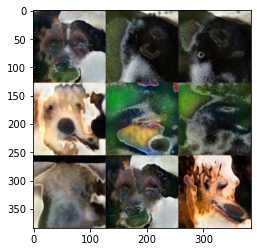

In [17]:
import matplotlib.pyplot as plt
noise = noise_image(9)
l_z = latent_z(9)
l_w = model2.S(l_z)
style = tf.stack([l_w for i in range(n_layers)],axis=1)
generated = model2.G([style,noise])
img = tf.concat([tf.concat([generated[3*i+k] for k in range(3)], axis=1) for i in range(3)], axis=0)
plt.imshow(img)